In [1]:
#dataset = 'RLP'
dataset = 'BW'

dem_resolution = 100 # [m]
dem_file = '/home/jens/daten/geometries/usgs_earth_explorer/merged_raster_100m.tif'

if dataset == 'RLP':
    boundary_file = "/home/jens/daten/RLP_temperatureLogs_shallow/geometries/RLP_boundary/landesgrenze_rlp.shp"
    path_regions = '/home/jens/daten/geometries/geological_regions/RLP/hydrogeology'

    db_temperatures = 'temperatures' # from log analysis
    quality_assessment = True
elif dataset == 'BW':
    boundary_file = "/home/jens/daten/BW_temperatureLogs_shallow/geometries/Verw-Grenzen_ALKIS/Verwaltungsgrenzen_NOrA_Dez_2022_ALKIS-Shape/v_al_land.shp"
    path_regions = '/home/jens/daten/geometries/geological_regions/BW/auswertungsregionen'
    db_temperatures = 'temperatures_approximation' # from landsurface extrapolation
    quality_assessment = False
else:
    print('dataset not supported')
    dem_file, boundary_file = None, None 

<h1> Import <h1>

<h2> Modules </h2>

In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from geoalchemy2 import Geometry

import geopandas as gpd
from shapely.geometry import Point
from shapely.affinity import scale

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from pyproj import Transformer

from scipy.stats import linregress

<h2> Borehole data </h2>

In [3]:
if dataset == 'RLP':
    columns_infos_unique = ['borehole_id', #'T_surface_modis',
                                                    'elevation', 
                                                    'sealing', 'vegetation',
                                                   'land_use', 'land_cover', 'tree_cover',
                                                    'utm_easting', 'utm_northing']
    columns_borehole_evaluation = ['borehole_id', #'T_surface_modis',
                                    'quality', 'deactivated', 'nr_samples', 'flow_info', 'date', 
                                   'depth_bottom', 'depth_top']
elif dataset == 'BW':
    columns_infos_unique = ['borehole_id', #'T_surface_modis',
                                                    'elevation', 
                                                    'sealing', 'vegetation',
                                                   'land_use', 'land_cover', 'tree_cover',
                                                    'utm_easting', 'utm_northing', 'date']
    columns_borehole_evaluation = ['borehole_id', #'T_surface_modis',
                                                    'quality', 'nr_samples', 'flow_info', 'deactivated', 'depth_bottom', 'depth_top']


user, password ='postgres', 'postgres'
schema, host = f'DB_{dataset}_temperature_shallow', '127.0.0.1'
connection_string='postgresql://{}:{}@{}:5432/{}'.format(user, password, host, schema)

engine = create_engine(connection_string)


df_fitting = pd.read_sql_query("SELECT * FROM fitting;", engine)
df_borehole_evaluation = pd.read_sql_query("SELECT * FROM borehole_evaluation;", engine)
df_sample_evaluation = pd.read_csv("/home/jens/daten/RLP_temperatureLogs_shallow/results/sampleEvaluation_RLP.csv")

df_temperatures = pd.read_sql_query(f"SELECT * FROM {db_temperatures};", engine)
df_temperatures.loc[df_temperatures['T_0'] > 1e6, 'T_0'] = np.nan

df_infos = pd.read_sql_query("SELECT * FROM log_infos;", engine)
df_infos.loc[:, 'nr_samples'] = df_infos.groupby('borehole_id')['borehole_id'].transform("count")
df_infos_unique = df_infos.drop_duplicates(subset='borehole_id', keep='first')

df = pd.merge(df_temperatures, df_infos_unique[columns_infos_unique], 
              on='borehole_id', how='left')

df = pd.merge(df, df_borehole_evaluation[columns_borehole_evaluation], 
              on='borehole_id', how='left')

df = pd.merge(df, df_fitting[['borehole_id', 'points', 'number_of_points']], on='borehole_id', how='left')


df["year"] = pd.to_numeric(df["date"].str[:4], errors="coerce")
df = df.rename(columns={"year": "Decade"})

df.shape

(1203, 122)

<h2> Regions </h2>

In [4]:
if dataset == 'RLP':
    regions_hg = [
        'rhine_graben_slab',
        'rhine_graben_zwischenscholle',
        'mainz_basin_tertiary',
        'quaternary_north_west',
        'quaternary_middle_rhine',
        'tertiary_quaternary_rhine_main',
        'palatinate_buntsandstein',
        'palatinate_muschelkalk',
        'triassic_north_west',
        'tertiary_north_west',    
        'palatinate_permokarbon',
        'perm_nahe_prims_basin',
        'palatinate_slate_mountain_range_south',
        'palatinate_slate_mountain_range_north',
        'lahn_dill',
        'westerwald_tertiary',
        'limestone_depression_buntsandstein_vulkanite',
        'kaenozoic_vulkanite'
    ]
    
    regions_main_colors = ["#1f77b4",
                           "#8c564b",
                           "#2ca02c",
                           "#ff7f0e",
                           "#9467bd",
                           "#d62728",  
                           "#1a1a1a", # "#7f7f7f"
                           "#e377c2",
                           "#9467bd"
                          ]
    
    df['region_hg'] = ''
    df['region_main'] = ''
    
    for region in regions_hg:
        shapefile = 'region_{}.shp'.format(region)
        
        polygon_gdf = gpd.read_file(path_regions + '/' + shapefile)  # Pfad zum Shapefile anpassen
        polygon_gdf = polygon_gdf.to_crs(epsg=25832)  # In UTM-Zone 33N umprojizieren (Beispiel für Deutschland)
        
        geometry = [Point(xy) for xy in zip(df["utm_easting"], df["utm_northing"])]
        gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:25832")  # Falls UTM-Zone 33N
        gdf_filtered = gdf[gdf.within(polygon_gdf.union_all())]
        #df_regions_main[region] = gdf_filtered.drop(columns="geometry")
        df.loc[gdf_filtered.index, 'region_hg'] = region

    

    df.loc[df['region_hg'].isin(['palatinate_buntsandstein', 'palatinate_muschelkalk']), 'region_main'] = 'palatinate_triassic'
    df.loc[df['region_hg'].isin(['quaternary_middle_rhine']), 'region_main'] = 'middle_rhein'
    df.loc[df['region_hg'].isin(['mainz_basin_tertiary', 'tertiary_quaternary_rhine_main']), 'region_main'] = 'mainz_basin'
    df.loc[df['region_hg'].isin(['palatinate_permokarbon', 'perm_nahe_prims_basin']), 'region_main'] = 'saar_nahe'
    df.loc[df['region_hg'].isin(['palatinate_slate_mountain_range_south', 'palatinate_slate_mountain_range_north',
                                'limestone_depression_buntsandstein_vulkanite', 
                                 'quaternary_north_west', 'tertiary_north_west', 'triassic_north_west',
                                'lahn_dill']), 'region_main'] = 'palatinate_slate'
    df.loc[df['region_hg'].isin(['westerwald_tertiary']), 'region_main'] = 'westerwald'
    df.loc[df['region_hg'].isin(['kaenozoic_vulkanite']), 'region_main'] = 'lake_laach'
    df.loc[df['region_hg'].isin(['rhine_graben_slab', 'rhine_graben_zwischenscholle']), 'region_main'] = 'upper_rhine_graben'
    
    #regions_main = df['region_main'].unique().tolist()
    regions_main = ['westerwald', 'lake_laach', 'palatinate_slate', 'palatinate_triassic', 
                    'saar_nahe', 'mainz_basin', 'upper_rhine_graben', 'middle_rhein']
elif dataset == 'BW':
    regions_main = [
        'odenwald',
        'black_forest',
        'swabian_alb',
        'voralb',
        'keuper_uplands',
        'alpine_foothills',
        'gaeu',
        'upper_rhine_graben'
    ]

    regions_main_colors = ["#1f77b4",
                           "#ff7f0e",
                           "#2ca02c", 
                           "#d62728",
                           "#9467bd", 
                           "#8c564b",
                           "#e377c2",
                           "#1a1a1a" # "#7f7f7f"
                          ]

    df['region_main'] = ''
    
    for region in regions_main:
        shapefile = 'region_{}.shp'.format(region)
        
        polygon_gdf = gpd.read_file(path_regions + '/' + shapefile)  # Pfad zum Shapefile anpassen
        polygon_gdf = polygon_gdf.to_crs(epsg=25832)  # In UTM-Zone 33N umprojizieren (Beispiel für Deutschland)
        
        geometry = [Point(xy) for xy in zip(df["utm_easting"], df["utm_northing"])]
        gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:25832")  # Falls UTM-Zone 33N
        gdf_filtered = gdf[gdf.within(polygon_gdf.union_all())]
        #df_regions_main[region] = gdf_filtered.drop(columns="geometry")
        df.loc[gdf_filtered.index, 'region_main'] = region

else:
    print('dataset not supported')
    dem_file, boundary_file = None, None 
    
    
regions_main

['odenwald',
 'black_forest',
 'swabian_alb',
 'voralb',
 'keuper_uplands',
 'alpine_foothills',
 'gaeu',
 'upper_rhine_graben']

<h2> Filter </h2>

In [5]:
df_filt = df
# remove unevaluated boreholes#
df_filt = df_filt[df_filt["deactivated"] == False ]
print(f'Active: {df_filt.shape[0]}')

if quality_assessment:
    df_filt = df_filt[df_filt["quality"] >= 0 ]
    print(f'And quality > 0: {df_filt.shape[0]}')
# remove boreholes form geotis
df_filt = df_filt[~df_filt['borehole_id'].str.startswith('GT_')] # deep logs from GeotIS (in RLP)

print(f'And without GeotIS logs: {df_filt.shape[0]}')
#df_filt[df_filt['Decade'] < 100]

df_filt_50 = df_filt[ (df_filt['depth_bottom'] >=50)&  (df_filt['depth_top'] <= 50)]
print(f'And at 50 m: {df_filt_50.shape[0]}')

Active: 1202
And without GeotIS logs: 1202
And at 50 m: 408


<h2> Geometries </h2>

In [6]:
src = rasterio.open(dem_file)

valid = df_filt['T_surface_landsat'].notna()
x_vals = df_filt.loc[valid, 'utm_easting']
y_vals = df_filt.loc[valid, 'utm_northing']

x_min, x_max = x_vals.min(), x_vals.max()
y_min, y_max = y_vals.min(), y_vals.max()


gridx = np.arange(x_min, x_max, dem_resolution)
gridy = np.arange(y_min, y_max, dem_resolution)

xx, yy = np.meshgrid(gridx, gridy)


transformer = Transformer.from_crs("EPSG:32632", "EPSG:4326", always_xy=True)
_xx, _yy =  transformer.transform(xx, yy)


######
dst_crs = "EPSG:32632"


# Berechne Transformation und neue Dimensionen
transform, width, height = calculate_default_transform(
    src.crs, dst_crs, src.width, src.height, *src.bounds)

# Initialisiere ein Array für die transformierten Daten
transformed_dem = np.empty((height, width), dtype=src.meta['dtype'])

# Transformiere das Raster
reproject(
    source=src.read(1),
    destination=transformed_dem,
    src_transform=src.transform,
    src_crs=src.crs,
    dst_transform=transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest
)

dem_extent = [transform[2]/1000, (transform[2] + width * transform[0])/1000, 
              (transform[5] + height * transform[4])/1000, transform[5]/1000]

dem_extent

[271.90872714534765, 652.0776190406452, 5205.157902580906, 5654.125412975522]

In [7]:
gdf = gpd.read_file(boundary_file)
gdf['geometry'] = gdf['geometry'].apply(lambda geom: scale(geom, xfact=.001, yfact=.001, origin=(0, 0)))


<h1> Figure dataset </h1>

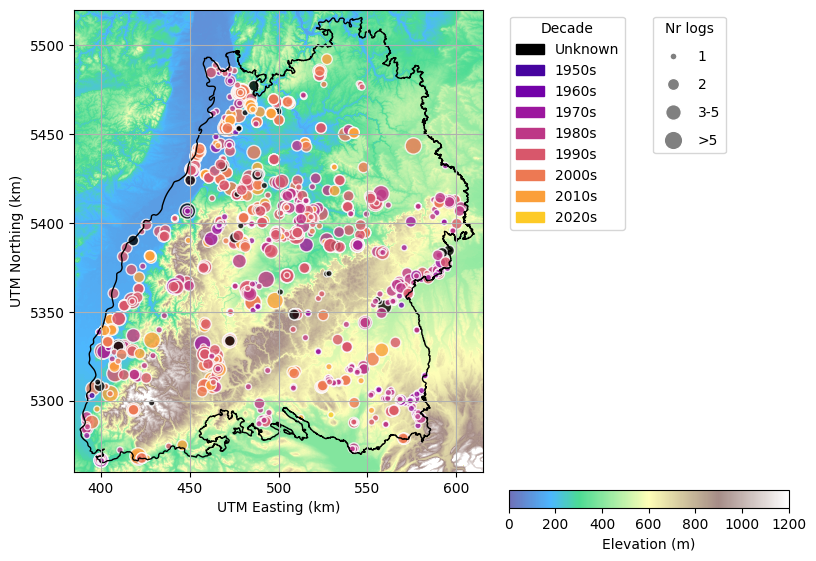

In [8]:
size_mapping = {
    '1': 20,
    '2': 60,
    '3-5': 100,
    '>5': 140
}

def size_category_label(s):
    if s == 1:
        return '1'
    elif s == 2:
        return '2'
    elif 3 <= s <= 5:
        return '3-5'
    else:
        return '>5'

df_filt = df_filt.copy()
df_filt['Nr logs'] = df_filt['nr_samples'].apply(size_category_label)
size_order = ['1', '2', '3-5', '>5']
df_filt['Nr logs'] = pd.Categorical(df_filt['Nr logs'], categories=size_order, ordered=True)

# Markergröße direkt aus size_mapping (Fläche in Punkten²)
df_filt['marker_size'] = df_filt['Nr logs'].map(size_mapping).astype(float)

# Koordinaten in km
df_filt['utm_easting_km'] = df_filt['utm_easting'] / 1000
df_filt['utm_northing_km'] = df_filt['utm_northing'] / 1000

fixed_decades = list(range(1950, 2030, 10))  # [1950, 1960, ..., 2020]

# Map Year auf feste Dekaden
df_filt['Decade'] = df_filt['Decade'].apply(lambda y: int((y // 10) * 10) if pd.notna(y) else 0)
df_filt['Decade'] = df_filt['Decade'].apply(lambda y: y if y in fixed_decades else 0)
df_filt['Decade_label'] = df_filt['Decade'].apply(lambda x: 'Unknown' if x==0 else f"{x}s")

# Farbpalette für alle festen Dekaden erstellen
palette = sns.color_palette("plasma", n_colors=len(fixed_decades))
palette_dict = {dec: color for dec, color in zip(fixed_decades, palette)}
palette_dict[0] = 'black'  # Unknown

# --- Plot ---
fig, ax = plt.subplots(figsize=(8,6))

# Scatterplot: s = Markerfläche, direkt aus size_mapping
ax.scatter(
    df_filt['utm_easting_km'],
    df_filt['utm_northing_km'],
    s=df_filt['marker_size'],  # **Fläche in Punkten²**
    c=df_filt['Decade'].map(palette_dict),
    edgecolors='w',
    alpha=0.8
)

im = ax.imshow(
    transformed_dem,
    extent=dem_extent,
    aspect='auto',
    alpha=0.7,
    vmin=0, vmax=1200,
    cmap='terrain'
)


gdf.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)

cbar_ax = fig.add_axes([0.8, 0.05, 0.35, 0.03])  # [left, bottom, width, height]
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Elevation (m)")

if dataset == 'RLP':
    ax.set_xlim([290.0, 470.0])
    ax.set_ylim([5420.0, 5650.0])
elif dataset == 'BW':
    ax.set_xlim([385.000, 615.000])
    ax.set_ylim([5260.000, 5520.000])
    
ax.set_xlabel('UTM Easting (km)')
ax.set_ylabel('UTM Northing (km)')

# --- Legende Decade (Farbe) oben rechts ---
legend_elements_color = [
    Patch(color=palette_dict[dec], label=df_filt.loc[df_filt['Decade']==dec, 'Decade_label'].iloc[0])
    for dec in sorted(df_filt['Decade'].unique())
]
first_legend = ax.legend(
    handles=legend_elements_color,
    loc='upper left',
    bbox_to_anchor=(1.05,1),
    title='Decade'
)
ax.add_artist(first_legend)

size_legend_order = ['1', '2', '3-5', '>5']
legend_elements_size = [
    Line2D([0],[0], marker='o', color='w', label=f'{s}',
           markerfacecolor='gray',
           markersize=(2*np.sqrt(size_mapping[s]/np.pi)))
    for s in size_legend_order
]
ax.legend(
    handles=legend_elements_size,
    loc='upper left',
    bbox_to_anchor=(1.4,1),
    title='Nr logs',
    labelspacing=1.,
    markerscale=1
)
ax.grid()

plt.savefig(f'{dataset}_logMap.png', dpi=300, bbox_inches='tight', transparent=True)

<h1> Figure elevation </h1>

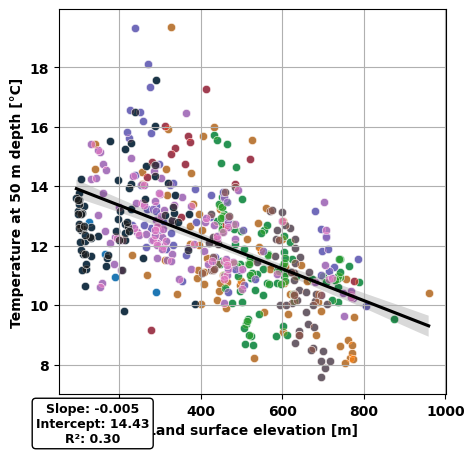

In [9]:
temp='T_50' # 'T_{depth}'

df_clean = df_filt.dropna(subset=[temp])
df_clean = df_clean[df_clean[temp]< 100]

fig, axes = plt.subplots(1, 1, figsize=(5, 5)) 
sns.scatterplot(x='elevation', y=temp, data=df_clean, ax=axes)

for ndx, region in enumerate(regions_main):
    df_clean_reg = df_clean[df_clean['region_main'] == region]
    sns.scatterplot(x='elevation', y=temp, data=df_clean_reg, ax=axes, color=regions_main_colors[ndx], alpha=.7)

sns.regplot(x='elevation', y=temp, data=df_clean, scatter=False, color='black')

slope, intercept, r_value, p_value, std_err = linregress(df_clean['elevation'], df_clean[temp])
text = f'Slope: {slope:.3f}\nIntercept: {intercept:.2f}\nR²: {r_value**2:.2f}'  # Formatiert die Werte
#plt.text(6, 5, text, fontsize=12, color='black', ha='center')
plt.gca().text(135, 5.4, text, fontsize=9, color='black', ha='center', zorder=10, fontweight='bold',
               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=1))

# legend
start_x = 180
start_y = 21.8
dy = -1  # vertikaler Abstand zwischen den Zeilen

axes.grid(True)
axes.set_xlabel('Land surface elevation [m]', fontsize=10, fontweight="bold")
axes.set_ylabel('Temperature at 50 m depth [°C]', fontsize=10, fontweight="bold")
axes.tick_params(axis='both', labelsize=10)

ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight("bold")

plt.savefig(f"{dataset}_elevation_regions.png", dpi=300, bbox_inches='tight')

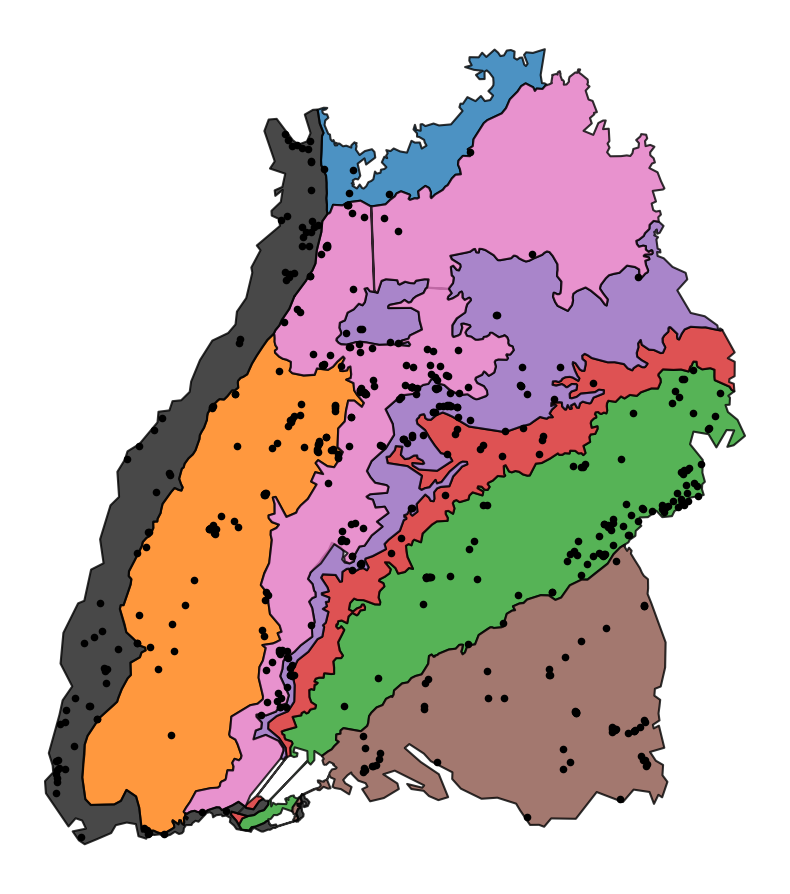

In [10]:
# map with regions

regions_list = []

if dataset == 'RLP':
    for region in regions_hg:
        try:
            region_main = df.loc[df['region_hg'] == region, 'region_main'].values[0]
            color = regions_main_colors[ regions_main.index(region_main)]
        except:
            print('No main region for ' + region)
            color = regions_main_colors[ regions_main.index('palatinate_slate')]
            
        shapefile = f'{path_regions}/region_{region}.shp'
        polygon_gdf = gpd.read_file(shapefile).to_crs(epsg=25832)
        polygon_gdf["region_id"] = region
        polygon_gdf["color"] = color
        regions_list.append(polygon_gdf)
elif dataset == 'BW':
    for ndx, region in enumerate(regions_main):
        color = regions_main_colors[ndx]
            
        shapefile = f'{path_regions}/region_{region}.shp'
        polygon_gdf = gpd.read_file(shapefile).to_crs(epsg=25832)
        polygon_gdf["region_id"] = region
        polygon_gdf["color"] = color
        regions_list.append(polygon_gdf)
    
regions_gdf = gpd.GeoDataFrame(pd.concat(regions_list, ignore_index=True), crs="EPSG:25832")


fig, ax = plt.subplots(figsize=(8, 10))

regions_gdf.plot(
    ax=ax,
    color=regions_gdf["color"],
    edgecolor="black",
    linewidth=1.5,
    alpha=0.8,
    zorder=1
)

df_clean = df_filt.dropna(subset=[temp])

gdf_points = gpd.GeoDataFrame(df_clean, 
                              geometry=gpd.points_from_xy(df_clean['utm_easting'], df_clean['utm_northing']),
                             crs=gdf.crs)

gdf_points.plot(ax=ax, color='black', markersize=20)


ax.set_axis_off()
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()

plt.savefig(f"{dataset}_regions.png", dpi=300, bbox_inches='tight', transparent=True)


In [11]:
depth_list_deep =  list(range(0, 310, 10)) + list(range(350, 1000, 50))
T_depth_list_deep = [ 'T_{}'.format(n) for n in depth_list_deep ]

boreholes_at_depth = {}
for T_depth in T_depth_list_deep:
    #for T_depth in T_depth_list:
    df_clean = df_filt.dropna(subset=[T_depth])
    boreholes_at_depth[T_depth] = df_clean.shape[0]
    # print('\t', T_depth,':', boreholes_at_depth[T_depth] )



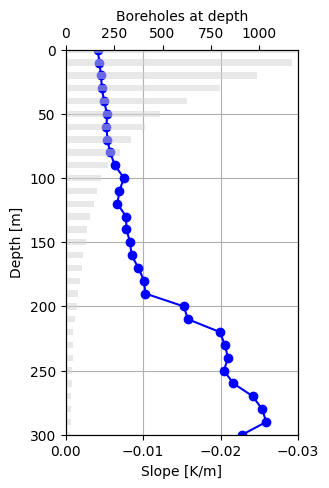

In [12]:
slope_list = [np.nan] * (len(T_depth_list_deep))
data = [None] * (len(T_depth_list_deep))

for ndx, T_depth in enumerate(T_depth_list_deep):
    df_clean = df_filt.dropna(subset=[T_depth])
    df_clean = df_clean[df_clean[T_depth]<100]
    df_clean = df_clean.dropna(subset=['elevation'])
    try:
        if df_clean.shape[0] > 1:
            slope, intercept, r_value, p_value, std_err = linregress(df_clean['elevation'], df_clean[T_depth])
            item = {'depth': T_depth, 'slope': slope, 'intercept': intercept, 
                    'r_value': r_value, 'p_value': p_value, 'std_err': std_err, 'anzahl': df_clean.shape[0]  }
            data[ndx] = item
            slope_list[ndx] = slope
            # print(f'{depth}: {slope}')
        else:
            pass
            # print(f'No value at depth {depth}')
    except:
        pass


fig, ax = plt.subplots(figsize=(3, 5))

# Erstelle die sekundäre x-Achse (twiny) für die Balken
ax2 = ax.twiny()
ax2.barh(depth_list_deep, boreholes_at_depth.values(), height=5, color='lightgray', alpha=0.5, zorder=1)
ax2.set_xlim(0, 1200)
#ax2.set_xticks(range(0, 151, 30))
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position("top")
ax2.set_xlabel('Boreholes at depth')
# Hintergrund der sekundären Achse transparent
ax2.patch.set_alpha(0)
# Setze diese Achse hinter Hauptachse
ax2.set_zorder(0)

# Zeichne anschließend die Linien auf der Hauptachse (mit höherem zorder)
index_first = 0
index_last = -5
ax.plot(np.array(slope_list[index_first:index_last]), 
        depth_list_deep[index_first:index_last], 
        marker='o', linestyle='-', color='b')#, label="Daten")

# Achsenanpassungen für die Hauptachse:
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_ylim([300, 0])
ax.set_xlim([0, -.03])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Slope [K/m]')
ax.grid(True)


# Stelle sicher, dass auch der Hintergrund der Hauptachse transparent ist:
ax.patch.set_alpha(0)

plt.savefig(f"{dataset}_elevation_depth.png", dpi=300, bbox_inches='tight')